<a href="https://colab.research.google.com/github/apd1995/AMP_matrix_recovery/blob/apd1995-JS-approx-jacobian-normal-cov-1/updating_params.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import json
import time
from datetime import datetime, timezone, timedelta
from google.cloud import bigquery
import multiprocessing as mp
from google.colab import auth
import matplotlib.pyplot as plt

In [3]:
auth.authenticate_user()

In [ ]:
default_directory = 'Andrew+Apratim+Dave/experimental_design'
import sys
use_default_directory = input("Please enter Y if your directory is Andrew+Apratim+Dave/experimental_design.\nPlease enter N if not. ")
if use_default_directory == 'Y':
  import_directory = default_directory
elif use_default_directory == 'N':
  import_directory = input("Please enter your working directory in Google Drive. \nFor example, when you go to Google Drive, if your module is located in Folder1 -> Folder2, please write Folder1/Folder2. ")
sys.path.append('/content/drive/MyDrive/'+str(import_directory))
from experimental_design import logreg_data, kalish_optimal_two_point_logistic, white_optimal_two_point_logistic
%load_ext google.colab.data_table

Please enter Y if your directory is Andrew+Apratim+Dave/experimental_design.
Please enter N if not. Y


In [4]:
def get_df_from_project(project_id, table_name):

  client = bigquery.Client(project=project_id)

  query = f"SELECT * FROM `{table_name}`"

  df = client.query(query).to_dataframe()

  return df

In [5]:
# df_integer_scale = get_df_from_project('hs-deep-lab-donoho', 'EMS.comr-N50-larger-grids')
# df_integer_scale

# df_AMP_coarse = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_blocksoft_02_1')
# df_AMP_coarse

# df_AMP = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_blocksoft_10_normal')
# df_AMP

# df_AMP = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_JS_1_normal')
# df_AMP

# df_AMP = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_normal_bayes_2_1')
# df_AMP

# df_AMP = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_normal_bayes_approx_jacobian')
# df_AMP

# df_AMP = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_JS_approx_jacobian_normal')
# df_AMP

df_AMP = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_JS_approx_jacobian_cov')
df_AMP

,nonzero_rows,num_measurements,signal_nrow,signal_ncol,mc,max_iter,err_tol,sparsity_tol,err_explosion_tol,selected_rows_frac,...,norm_2_2_rec,norm_2_infty_true,norm_2_infty_rec,soft_sparsity,nonzero_rows_rec,tpr,tnr,min_rel_err,iter_count,time_seconds
0,240,225,800,5,49,500,0.00001,0.0001,100,1.0,...,61.800530,1.911687,341.175469,0.68125,545,0.326786,0.700000,1.000000,244,1001.99
1,240,225,800,5,10,500,0.00001,0.0001,100,1.0,...,6.324923,1.974738,23.573070,0.69250,554,0.307143,0.691667,1.000000,500,2035.11
2,240,225,800,5,38,500,0.00001,0.0001,100,1.0,...,6.321328,1.913364,28.431236,0.70125,561,0.314286,0.737500,1.000000,500,2039.86
3,240,225,800,5,12,500,0.00001,0.0001,100,1.0,...,4.904205,2.360271,23.083327,0.70500,564,0.291071,0.695833,1.000000,500,2111.48
4,240,225,800,5,26,500,0.00001,0.0001,100,1.0,...,55.873983,1.655360,227.858216,0.71000,568,0.301786,0.737500,1.000000,457,1897.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33482,720,742,800,5,17,500,0.00001,0.0001,100,1.0,...,0.946164,2.025980,2.089699,0.96750,774,0.325000,1.000000,0.105859,500,2597.14
33483,720,744,800,5,6,500,0.00001,0.0001,100,1.0,...,0.935355,1.784544,1.821807,0.96750,774,0.325000,1.000000,0.053804,500,2608.09
33484,720,782,800,5,0,500,0.00001,0.0001,100,1.0,...,97.713359,2.069213,304.435435,0.96750,774,0.325000,1.000000,0.387708,48,223.54
33485,240,266,800,5,4,500,0.00001,0.0001,100,0.3,...,1.144028,2.013433,3.748498,0.73375,587,0.291071,0.791667,1.000000,500,586.53


In [ ]:
df_small = df_AMP[df_AMP['sparsity'].isin([0.3])]
df_small
# np.mean(df_small['time_seconds'])

,nonzero_rows,num_measurements,signal_nrow,signal_ncol,mc,max_iter,err_tol,sparsity_tol,err_explosion_tol,selected_rows_frac,...,norm_2_2_rec,norm_2_infty_true,norm_2_infty_rec,soft_sparsity,nonzero_rows_rec,tpr,tnr,min_rel_err,iter_count,time_seconds
457,240,423,800,5,3,500,0.00001,0.0001,100,1.0,...,56.872866,2.300077,242.384382,0.79000,632,0.300000,1.0,0.479645,163,1018.69
458,240,426,800,5,2,500,0.00001,0.0001,100,1.0,...,64.015924,2.005103,320.794893,0.81500,652,0.264286,1.0,0.300331,142,885.41
459,240,452,800,5,24,500,0.00001,0.0001,100,1.0,...,57.819025,2.247052,233.546031,0.79625,637,0.291071,1.0,0.578421,35,221.43
460,240,449,800,5,22,500,0.00001,0.0001,100,1.0,...,0.557188,1.821521,1.821495,0.31750,254,0.975000,1.0,0.000912,127,792.34
461,240,410,800,5,22,500,0.00001,0.0001,100,1.0,...,0.549577,1.733417,1.732458,0.32000,256,0.971429,1.0,0.000998,393,1842.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18380,240,398,800,5,4,500,0.00001,0.0001,100,1.0,...,0.551996,1.894838,1.874381,0.78000,624,0.314286,1.0,0.079575,500,2315.94
18381,240,425,800,5,5,500,0.00001,0.0001,100,1.0,...,57.701926,2.185021,244.961920,0.78000,624,0.314286,1.0,0.576385,88,395.12
18382,240,437,800,5,19,500,0.00001,0.0001,100,1.0,...,76.071834,1.735680,261.237261,0.81125,649,0.269643,1.0,0.002684,306,1344.56
18383,240,444,800,5,8,500,0.00001,0.0001,100,1.0,...,58.138176,1.775680,292.210483,0.81125,649,0.269643,1.0,0.562161,141,592.30


(9465, 832.98, 739.8657886951928, 0.8227152667723191)

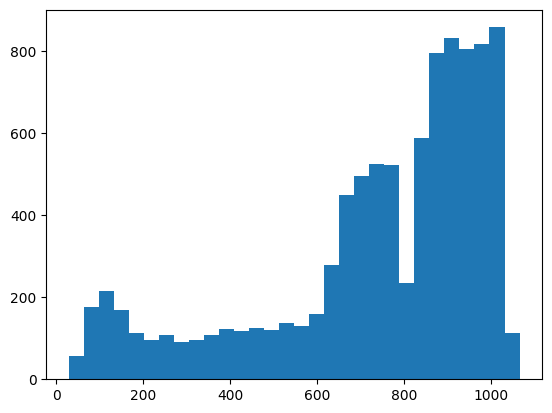

In [ ]:
df = df_AMP[df_AMP['signal_nrow']>=400]
import matplotlib.pyplot as plt
plt.hist(df['time_seconds'], bins = 30)
df.shape[0], np.median(df['time_seconds']), np.mean(df['time_seconds']), np.mean(df['time_seconds']>500)

Use the following function to use subsets of the full dataset, which is much easier to handle considering memory limitations.

In [ ]:
def subset_df_from_project(project_id, table_name, signal_nrow):
  client = bigquery.Client(project=project_id)

  query = f"SELECT * FROM `{table_name}` WHERE signal_nrow = {signal_nrow}"

  df = client.query(query).to_dataframe()

  return df

# AMP_course_20 = subset_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_blocksoft_02', 20)
# AMP_course_20

AMP_course_small = subset_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_normal_bayes_2_1', 5)
AMP_course_small.to_csv("temp.csv")

In [ ]:
df_integer_scale = get_df_from_project('hs-deep-lab-donoho', 'EMS.comr-N50-larger-grids')

In [6]:
def save_df_in_drive(output_df):

  output_name = input("Please write the name with which you'd like to store the output. ")
  default_directory = 'Andrew+Apratim+Dave/experimental_design'
  user_decision = input("Do you want to save your output in the default directory, that is, Andrew+Apratim+Dave/experimental_design? \nWrite Y for yes and N for no. ")

  if user_decision == "Y":
    output_df.to_csv("/content/drive/MyDrive/"+str(default_directory)+"/"+str(output_name))
    return
  elif user_decision == "N":
    output_directory = input("Please write the location you want your output file to be in, in Google Drive. \nIf it's Folder1 -> Folder2, write Folder1/Folder2 ")
    output_df.to_csv("/content/drive/MyDrive/"+str(output_directory)+"/"+str(output_name))
    return
  else:
    print("Invalid choice. Please enter only Y or N. ")
    return

# save_df_in_drive(AMP_course_20)
save_df_in_drive(df_AMP)
# del df_integer_scale
# save_df_in_drive(df_integer_scale)

Please write the name with which you'd like to store the output. AMP_JS_normal_800.csv
Do you want to save your output in the default directory, that is, Andrew+Apratim+Dave/experimental_design? 
Write Y for yes and N for no. Y


In [7]:
%load_ext rpy2.ipython

We need the bigrquery function to read gbq database. Upload the json file containing the key to session storage.

In [ ]:
%%R
# install.packages("bigrquery")
library(bigrquery)
Sys.setenv(GOOGLE_APPLICATION_CREDENTIALS = "key_file.json")

In [ ]:
%%R
project_id <- "hs-deep-lab-donoho"
sql_query <- "SELECT signal_nrow, signal_ncol FROM EMS.comr-N50-larger-grid"

result <- query_exec(sql_query, project = project_id, billing = project_id)

data_frame <- as.data.frame(result)


In [8]:
%%R
library(tidyverse)
library(dplyr)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [9]:
%%R
#filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_combined.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_integer_scale_full.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_AMP_blocksoft.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_course_20.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_AMP_blocksoft_corrected.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_AMP_blocksoft_larger.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_comr.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_JS_poisson.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_JS_normal.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_normal_bayes.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_normal_bayes_approx_jacobian.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_JS_normal_approx_jacobian.csv"
filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_JS_normal_800.csv"
raw_data = read.csv(filename)
raw_data = subset(raw_data, select = -X)
raw_data = unique(raw_data)
row.names(raw_data) = 1:nrow(raw_data)
head(raw_data)

  nonzero_rows num_measurements signal_nrow signal_ncol mc max_iter err_tol
1          240              225         800           5 49      500   1e-05
2          240              225         800           5 10      500   1e-05
3          240              225         800           5 38      500   1e-05
4          240              225         800           5 12      500   1e-05
5          240              225         800           5 26      500   1e-05
6          240              225         800           5 29      500   1e-05
  sparsity_tol err_explosion_tol selected_rows_frac sparsity
1        1e-04               100                  1      0.3
2        1e-04               100                  1      0.3
3        1e-04               100                  1      0.3
4        1e-04               100                  1      0.3
5        1e-04               100                  1      0.3
6        1e-04               100                  1      0.3
  undersampling_ratio    rel_err   avg_er

In [ ]:
%%R
raw_data$min_rel_err[is.na(raw_data$rel_err)] = 1
raw_data[1,]

  nonzero_rows num_measurements signal_nrow signal_ncol mc max_iter err_tol
1           10               70         200           5  8      500   1e-05
  sparsity_tol err_explosion_tol sparsity undersampling_ratio      rel_err
1        1e-04               100     0.05                0.35 0.0006925363
       avg_err  max_row_err norm_2_1_true norm_2_1_rec norm_2_2_true
1 0.0001333449 0.0009051141    0.04129514   0.04128825     0.1925457
  norm_2_2_rec norm_2_infty_true norm_2_infty_rec soft_sparsity
1    0.1925023          1.305325         1.304695          0.05
  nonzero_rows_rec tpr tnr  min_rel_err iter_count time_seconds
1               10   1   1 0.0006925363          8         8.36


In [ ]:
%%R
#helper functions
deno_integrand = function(x, B, tau_sq){
    tau = sqrt(tau_sq)
    return((sqrt(x) - tau)*dchisq(x, B))
}

deno_integral = function(B, tau_sq){
    return(integrate(deno_integrand, lower = tau_sq, upper = Inf, B, tau_sq)$value)
}

num_integrand = function(x, B, tau_sq){
    tau = sqrt(tau_sq)
    return((sqrt(x) - tau)^2*dchisq(x, B))
}

num_integral = function(B, tau_sq){
    return(integrate(num_integrand, lower = tau_sq, upper = Inf, B, tau_sq)$value)
}

h = function(B, tau_sq){
    return(sqrt(tau_sq)/deno_integral(B, tau_sq))
}

g = function(B, tau_sq){
    return(sqrt(tau_sq)*num_integral(B, tau_sq)/deno_integral(B, tau_sq))
}

tau_sq_optim_eqn = function(tau_sq, sparsity, B){
    return(h(B, tau_sq)+1-(1/sparsity))
}

#giving a huge upper bound 1e+50 instead of Inf as otherwise uniroot function breaks
tau_sq_optim = function(sparsity, B){
    res = uniroot(tau_sq_optim_eqn, c(0, 1e+100), sparsity, B)$root
    return(res)
}

#main function delivering delta PT value for given sparsity and B
predicted_delta_PT = function(sparsity, B){
    tau_sq = tau_sq_optim(sparsity, B)
    return((B+tau_sq+g(B, tau_sq))/(B*(1+h(B, tau_sq))))
}

predicted_delta_PT(0.25, 5)

[1] 0.4838218


In [10]:
%%R
get_LD50 = function(x, y){
    if(sum(y) == 0){
        return(1)
    }
    else if(sum(y) == length(y)){
        return(0)
    }
    else{
        logreg = glm(y~x, family = binomial(link = "logit"))
        intercept = logreg$coefficients[1]
        slope = logreg$coefficients[2]
        LD50 = unname(-intercept/slope)
        return(min(max(LD50, 0), 1))
        }
}


empirical_PT_df = function(df, sparsity_lower_bound, sparsity_upper_bound){
    dat = df %>%
    filter(sparsity>=sparsity_lower_bound, sparsity<=sparsity_upper_bound) %>%
    mutate(success = as.integer(rel_err < 10**2 * err_tol)) %>%
    arrange(signal_nrow, signal_ncol, nonzero_rows, sparsity, num_measurements, undersampling_ratio, mc) %>%
    group_by(signal_nrow, signal_ncol, nonzero_rows, sparsity) %>%
    summarise(empirical_delta_PT = get_LD50(undersampling_ratio, success))

    # dat_small = dat %>%
    # filter(signal_nrow == min(dat$signal_nrow)) %>%
    # mutate(pred_delta_PT = mapply(predicted_delta_PT, sparsity, signal_ncol))

    # dat$pred_delta_PT = rep(dat_small$pred_delta_PT, as.integer(nrow(dat)/nrow(dat_small)))

    return(dat)
}


# write.csv(res, "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_intger_scale.csv")

In [14]:
%%R
res_JS_normal_800 = empirical_PT_df(filter(raw_data, selected_rows_frac == 1.0), 0, 1)
filter(res_JS_normal_800, signal_nrow == 800)

`summarise()` has grouped output by 'signal_nrow', 'signal_ncol',
'nonzero_rows'. You can override using the `.groups` argument.
# A tibble: 19 × 5
# Groups:   signal_nrow, signal_ncol, nonzero_rows [19]
   signal_nrow signal_ncol nonzero_rows sparsity empirical_delta_PT
         <int>       <int>        <int>    <dbl>              <dbl>
 1         800           5           40     0.05              0.334
 2         800           5           80     0.1               0.364
 3         800           5          120     0.15              0.401
 4         800           5          160     0.2               0.442
 5         800           5          200     0.25              0.477
 6         800           5          240     0.3               0.526
 7         800           5          280     0.35              0.551
 8         800           5          320     0.4               0.586
 9         800           5          360     0.45              0.625
10         800           5          400     0.5 

In [21]:
%%R
df = raw_data %>% filter(signal_nrow == 800) %>% filter(sparsity == 0.3) %>% filter(selected_rows_frac == 1.0)
df$success = as.integer(df$rel_err < 1e-3)
success_prop = sum(df$success)/length(df$success)
success_prop

[1] 0.5043817


In [22]:
%%R
# correction of intercept
y = df$success
x = df$undersampling_ratio
logreg = glm(y~x, family = binomial(link = "logit"))
intercept = logreg$coefficients[1]
slope = logreg$coefficients[2]
c(get_LD50(x, y), (-intercept + log(((1-0.495)/0.495) * (success_prop/(1-success_prop))))/slope)

            (Intercept) 
  0.5260298   0.5282829 


In [20]:
%%R
nrow(filter(raw_data, selected_rows_frac == 0.3))

[1] 5000


In [ ]:
%%R
filter(res_JS_normal_approx_jacobian, signal_nrow == 800)$empirical_delta_PT

 [1] 0.3563443 0.3907283 0.4261754 0.4627548 0.4958638 0.5329545 0.5675437
 [8] 0.6035253 0.6385110 0.6758197 0.7098257 0.7453270 0.7803912 0.8158612
[15] 0.8509555 0.8873299 0.9208893 0.9575433 0.9895159


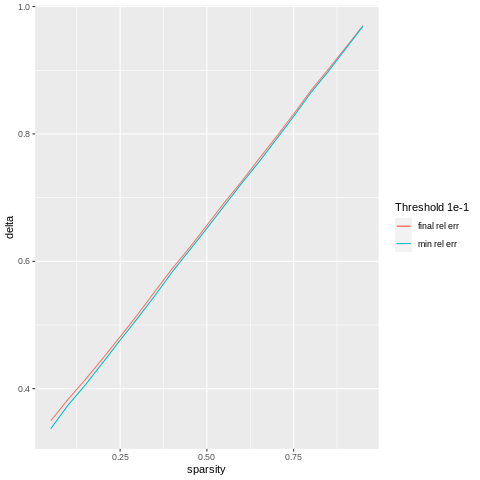

In [ ]:
%%R
g4 <- ggplot(dplyr::filter(res_JS_normal_approx_jacobian, signal_nrow == 400), aes(x = sparsity, y = delta)) +
      geom_line(aes(x = sparsity, y = empirical_delta_PT, color = "final rel err")) +
      # geom_line(data = res_normal_bayes_approx_jacobian, aes(x = sparsity, y = empirical_delta_PT, color = as.factor(signal_nrow)))
      geom_line(data = dplyr::filter(res_JS_normal_approx_jacobian_min, signal_nrow == 400), aes(x = sparsity, y = empirical_delta_PT, color = "min rel err"))+
      # geom_line(aes(x = sparsity, y = sparsity, color = "diagonal"))
      scale_color_discrete(name = "Threshold 1e-1")
g4

In [ ]:
%%R
res_JS_normal_approx_jacobian_min

# A tibble: 114 × 5
# Groups:   signal_nrow, signal_ncol, nonzero_rows [114]
   signal_nrow signal_ncol nonzero_rows sparsity empirical_delta_PT
         <int>       <int>        <int>    <dbl>              <dbl>
 1         100           5            5     0.05              0.366
 2         100           5           10     0.1               0.387
 3         100           5           15     0.15              0.417
 4         100           5           20     0.2               0.455
 5         100           5           25     0.25              0.484
 6         100           5           30     0.3               0.518
 7         100           5           35     0.35              0.556
 8         100           5           40     0.4               0.593
 9         100           5           45     0.45              0.627
10         100           5           50     0.5               0.658
# ℹ 104 more rows
# ℹ Use `print(n = ...)` to see more rows


In [ ]:
# risk of positive part james stein estimator at 0
%%R
JS_risk_at_zero = function(d){
    integrand = function(x){
        return((1-((d-2)/x))^2*x*dchisq(x, d))
    }
    return(integrate(integrand, d-2, Inf)$value/d)
}

predicted_JS_PT = function(sparsity, d){
    return(sparsity + ((1-sparsity)*JS_risk_at_zero(d)))
}

predicted_JS_PT(0.3, 5)

[1] 0.495996


In [ ]:
%%R
# James Stein
res_JS_normal_approx_jacobian = res_JS_normal_approx_jacobian %>%
mutate(pred_JS_PT = mapply(predicted_JS_PT, sparsity, signal_ncol))

In [ ]:
%%R
f = function(tau, x, y){
    logreg = glm(y~x, family = binomial(link = "logit"))
    intercept = logreg$coefficients[1]
    slope = logreg$coefficients[2]
    return(tau + log(tau/(1-tau))/slope +intercept/slope - log(sum(y == 1)/sum(y == 0))/slope)
}


uniroot(f, c(0, 1), x = x, y = y)

$root
[1] 0.3441466

$f.root
           x 
1.197989e-06 

$iter
[1] 6

$init.it
[1] NA

$estim.prec
[1] 6.103516e-05



In [ ]:
%%R
# JS upper bound (risk of OG JS, not positive part)
predicted_JS_upper_bound = function(sparsity, signal_ncol){
    return((1-sparsity)*2/signal_ncol + sparsity)
}

# JS approximate by taking upto 1st leading order term from asymptotic expansion
predicted_JS_approx_1st = function(sparsity, signal_ncol){
    return((1-sparsity)*(1/signal_ncol) + sparsity)
}

# JS approximate by taking upto 2nd leading order term from asymptotic expansion
predicted_JS_approx_2nd = function(sparsity, signal_ncol){
    return((1-sparsity)*(1/signal_ncol + 0.752/signal_ncol^(3/2)) + sparsity)
}

res_normal_js = res_normal_js %>%
mutate(pred_JS_upper_bound = mapply(predicted_JS_upper_bound, sparsity, signal_ncol)) %>%
mutate(pred_JS_approx_2nd = mapply(predicted_JS_approx_2nd, sparsity, signal_ncol)) %>%
mutate(pred_JS_approx_1st = mapply(predicted_JS_approx_1st, sparsity, signal_ncol))


In [ ]:
%%R
# convex optimization / blocksoft
res_normal_js = res_normal_js %>%
mutate(pred_blocksoft_PT = mapply(predicted_delta_PT, sparsity, signal_ncol))

In [ ]:
%%R
# Important: don't run this!
head(res)
# write.csv(res, "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_integer_scale.csv")
# write.csv(res, "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_AMP_blocksoft_threshold_corrected.csv")
# write.csv(res, "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_AMP_blocksoft_larger.csv")
# write.csv(res, "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_integer_scale_corrected.csv")
write.csv(res, "PT_data_comr.csv")

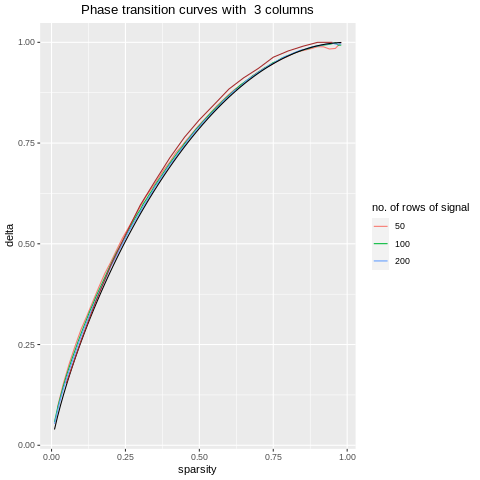

In [ ]:
%%R
B = 3
df1 = read.csv("/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_integer_scale_corrected.csv", row.names = 1)
# df2 = read.csv("/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_AMP_blocksoft_larger.csv", row.names = 1)
df2 = res

df1_100 = df1 %>% filter(signal_ncol == B)
df2_small = df2 %>% filter(signal_ncol == B)
g3 <- ggplot(df1_100, aes(x = sparsity, y = delta)) +
    labs(title = paste("Phase transition curves with ", B, "columns")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_line(aes(x = sparsity, y = empirical_delta_PT, color = as.factor(signal_nrow)))+
    scale_color_discrete(name = "no. of rows of signal") +
    geom_line(aes(x = sparsity, y = pred_delta_PT), color = "black") +
    geom_line(data = df2_small, aes(x = sparsity, y = empirical_delta_PT), color = "brown")

g3

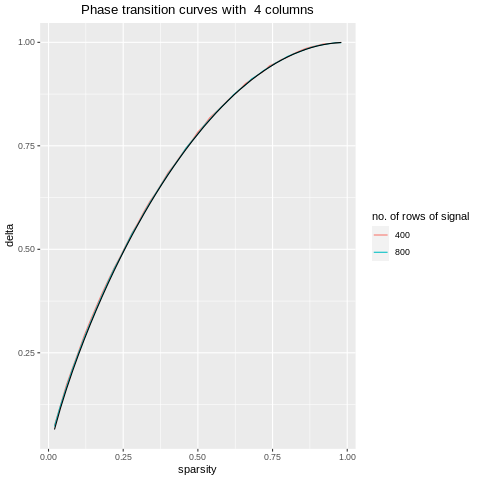

In [ ]:
%%R
B = 4
res_small = res %>% filter(signal_ncol == B)
g2 <- ggplot(res_small, aes(x = sparsity, y = delta)) +
    labs(title = paste("Phase transition curves with ", B, "columns")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_line(aes(x = sparsity, y = empirical_delta_PT, color = as.factor(signal_nrow)))+
    scale_color_discrete(name = "no. of rows of signal", labels = c("400", "800")) +
    geom_line(aes(x = sparsity, y = pred_delta_PT), color = "black")

g2

# ggsave(paste("/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_PT_plot_B=", B, ".png", sep = ""), g2)

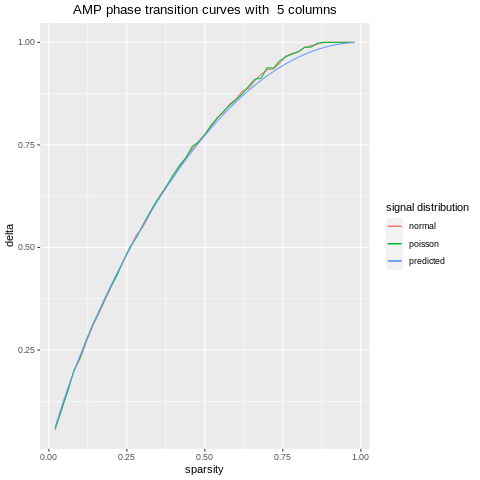

In [ ]:
%%R
B = 5
g2 <- ggplot(res_normal, aes(x = sparsity, y = delta)) +
    labs(title = paste("AMP phase transition curves with ", B, "columns")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_line(aes(x = sparsity, y = empirical_delta_PT, color = "normal"))+
    geom_line(data = res_poisson, aes(x = sparsity, y = empirical_delta_PT, color = "poisson")) +
    geom_line(aes(x = sparsity, y = pred_delta_PT, color = "predicted")) +
    scale_color_discrete(name = "signal distribution")
g2

In [ ]:
%%R
dat = read.csv('normal_bayes_PT.csv')

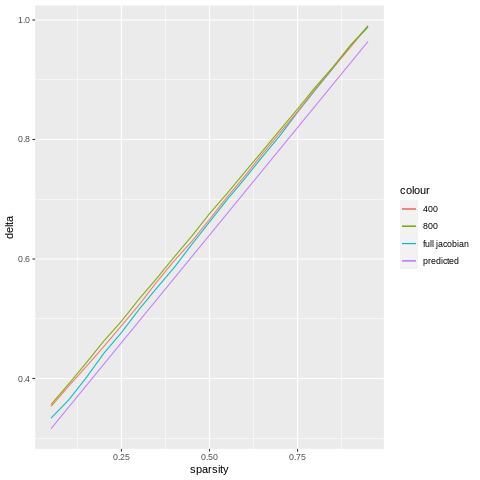

In [ ]:
%%R
g4 <- ggplot(res_JS_normal_800, aes(x = sparsity, y = delta)) +
      geom_line(aes(x = sparsity, y = empirical_delta_PT, color = "full jacobian"))+
      geom_line(aes(x = sparsity, y = pred_JS_PT, color = "predicted")) +
      geom_line(data = dat, aes(x = sparsity, y = empirical_delta_PT, color = as.factor(signal_nrow)))
      # geom_line(aes(x = sparsity, y = sparsity, color = "diagonal"))
g4

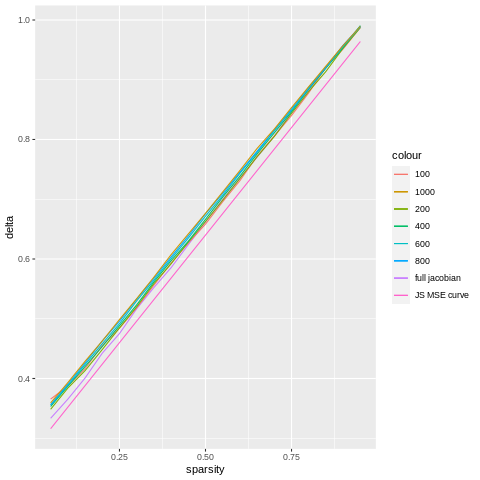

In [ ]:
%%R
g4 <- ggplot(res_JS_normal_800, aes(x = sparsity, y = delta)) +
      geom_line(aes(x = sparsity, y = empirical_delta_PT, color = "full jacobian"))+
      # geom_line(data = res_normal_bayes_approx_jacobian, aes(x = sparsity, y = empirical_delta_PT, color = as.factor(signal_nrow)))
      geom_line(aes(x = sparsity, y = pred_JS_PT, color = "JS MSE curve")) +
      geom_line(data = res_JS_normal_approx_jacobian, aes(x = sparsity, y = empirical_delta_PT, color = as.factor(signal_nrow)))
g4

In [ ]:
%%R
dat = dplyr::filter(res_JS_normal_approx_jacobian, signal_nrow %in% c(400, 800))
dat

# A tibble: 38 × 6
# Groups:   signal_nrow, signal_ncol, nonzero_rows [38]
   signal_nrow signal_ncol nonzero_rows sparsity empirical_delta_PT pred_JS_PT
         <int>       <int>        <int>    <dbl>              <dbl>      <dbl>
 1         400           5           20     0.05              0.353      0.316
 2         400           5           40     0.1               0.387      0.352
 3         400           5           60     0.15              0.420      0.388
 4         400           5           80     0.2               0.454      0.424
 5         400           5          100     0.25              0.488      0.460
 6         400           5          120     0.3               0.523      0.496
 7         400           5          140     0.35              0.562      0.532
 8         400           5          160     0.4               0.597      0.568
 9         400           5          180     0.45              0.630      0.604
10         400           5          200     0.5         

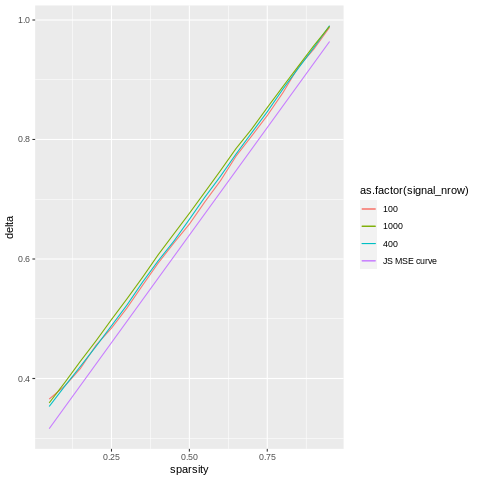

In [ ]:
%%R
g4 <- ggplot(dat, aes(x = sparsity, y = delta)) +
      geom_line(aes(x = sparsity, y = empirical_delta_PT, color = as.factor(signal_nrow))) +
      geom_line(aes(x = sparsity, y = pred_JS_PT, color = "JS MSE curve"))
g4

In [ ]:
%%R
write.csv(dat, "temp.csv")

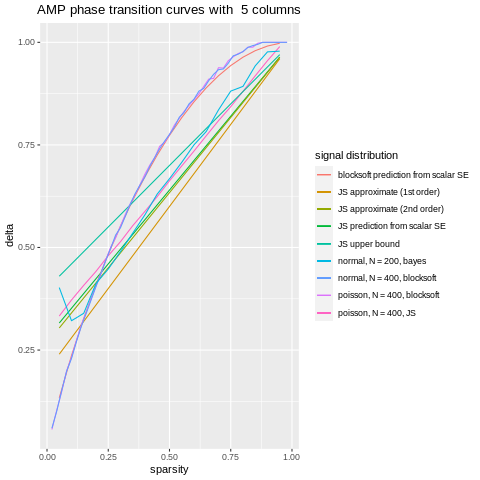

In [ ]:
%%R
# james stein plot
B = 5
g2 <- ggplot(res_poisson_js, aes(x = sparsity, y = delta)) +
    labs(title = paste("AMP phase transition curves with ", B, "columns")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_line(aes(x = sparsity, y = empirical_delta_PT, color = "poisson, N = 400, JS"))+
    geom_line(aes(x = sparsity, y = pred_JS_PT, color = "JS prediction from scalar SE")) +
    geom_line(aes(x = sparsity, y = pred_blocksoft_PT, color = "blocksoft prediction from scalar SE")) +
    geom_line(aes(x = sparsity, y = pred_JS_upper_bound, color = "JS upper bound")) +
    geom_line(aes(x = sparsity, y = pred_JS_approx_1st, color = "JS approximate (1st order)")) +
    geom_line(aes(x = sparsity, y = pred_JS_approx_2nd, color = "JS approximate (2nd order)")) +
    geom_line(data = res_poisson_bs, aes(x = sparsity, y = empirical_delta_PT, color = "poisson, N = 400, blocksoft"))+
    geom_line(data = res_normal_bs, aes(x = sparsity, y = empirical_delta_PT, color = "normal, N = 400, blocksoft"))+
    geom_line(data = res_normal_bayes, aes(x = sparsity, y = empirical_delta_PT, color = "normal, N = 200, bayes"))+
    scale_color_discrete(name = "signal distribution")
g2

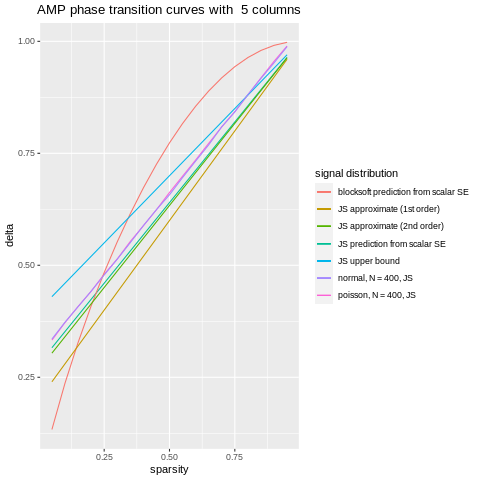

In [ ]:
%%R
# james stein plot
B = 5
g2 <- ggplot(res_poisson_js, aes(x = sparsity, y = delta)) +
    labs(title = paste("AMP phase transition curves with ", B, "columns")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_line(aes(x = sparsity, y = empirical_delta_PT, color = "poisson, N = 400, JS"))+
    geom_line(aes(x = sparsity, y = pred_JS_PT, color = "JS prediction from scalar SE")) +
    geom_line(aes(x = sparsity, y = pred_blocksoft_PT, color = "blocksoft prediction from scalar SE")) +
    geom_line(aes(x = sparsity, y = pred_JS_upper_bound, color = "JS upper bound")) +
    geom_line(aes(x = sparsity, y = pred_JS_approx_1st, color = "JS approximate (1st order)")) +
    geom_line(aes(x = sparsity, y = pred_JS_approx_2nd, color = "JS approximate (2nd order)")) +
    geom_line(data = res_normal_js, aes(x = sparsity, y = empirical_delta_PT, color = "normal, N = 400, JS"))+
    scale_color_discrete(name = "signal distribution")
g2

In [ ]:
%%R
write.csv(res, "temp.csv")

In [ ]:
AMP_PT_df = pd.read_csv("/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_AMP_blocksoft.csv", index_col = 0)
AMP_PT_df

,signal_nrow,signal_ncol,nonzero_rows,sparsity,empirical_delta_PT,pred_delta_PT
1,100,1,5,0.05,0.204887,0.203900
2,100,1,10,0.10,0.354998,0.328796
3,100,1,15,0.15,0.474997,0.427912
4,100,1,20,0.20,0.575218,0.511130
5,100,1,25,0.25,0.625004,0.582858
...,...,...,...,...,...,...
91,100,5,75,0.75,0.950000,0.943411
92,100,5,80,0.80,1.000000,0.963783
93,100,5,85,0.85,1.000000,0.979628
94,100,5,90,0.90,1.000000,0.990946


In [ ]:
def update_undersampling_int_grid(PT_df, signal_nrow, signal_ncol, nonzero_rows):

  empirical_PT_row = PT_df[(PT_df['signal_nrow'] == signal_nrow) & (PT_df['signal_ncol'] == signal_ncol) & (PT_df['nonzero_rows'] == nonzero_rows)]
  empirical_PT = empirical_PT_row['empirical_delta_PT'].item()
  undersampling_int_lower = max(1, int(signal_nrow * max(0, empirical_PT - 0.1)))
  undersampling_int_upper = min(signal_nrow - 1, int(signal_nrow * min(1, empirical_PT + 0.1)))
  return list(range(undersampling_int_lower, undersampling_int_upper + 1))

# update_undersampling_int_grid(empirical_PT_df, 50, 5, 4)
update_undersampling_int_grid(AMP_PT_df, 100, 2, 20)

[37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57]

In [ ]:
# coarser sparsity grid

def update_undersampling_int_grid_coarse(PT_df, signal_nrow, signal_ncol, sparsity):

  empirical_PT_row = PT_df[(PT_df['signal_nrow'] == signal_nrow) & (PT_df['B'] == signal_ncol) & (PT_df['sparsity'] == sparsity)]
  empirical_PT = empirical_PT_row['empirical_delta_PT'].item()
  undersampling_int_lower = max(1, int(signal_nrow * max(0, empirical_PT - 0.1)))
  undersampling_int_upper = min(signal_nrow - 1, int(signal_nrow * min(1, empirical_PT + 0.1)))
  return list(range(undersampling_int_lower, undersampling_int_upper + 1))

update_undersampling_int_grid_coarse(empirical_PT_df, 200, 1, 0.01)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35]

In [ ]:
PT_df = pd.read_csv("/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_integer_scale.csv", index_col = 0)
PT_df

,signal_nrow,signal_ncol,nonzero_rows,sparsity,empirical_delta_PT,pred_delta_PT
1,50,1,1,0.02,0.096124,0.104181
2,50,1,2,0.04,0.164638,0.173781
3,50,1,3,0.06,0.222378,0.231873
4,50,1,4,0.08,0.270099,0.282870
5,50,1,5,0.10,0.315671,0.328796
...,...,...,...,...,...,...
1231,200,5,190,0.95,0.995588,0.997742
1232,200,5,192,0.96,0.995760,0.998547
1233,200,5,194,0.97,0.996238,0.999182
1234,200,5,196,0.98,0.996504,0.999634


In [ ]:
# coarser sparsity grid: undersampling based on predicted

def update_undersampling_int_grid_coarse_pred(PT_df, signal_nrow, signal_ncol, sparsity, band_half_width):
  PT_row = PT_df[(PT_df['signal_nrow'] == 100) & (PT_df['signal_ncol'] == signal_ncol) & (PT_df['sparsity'] == sparsity)]
  PT = PT_row['pred_delta_PT'].item()
  undersampling_int_lower = max(1, int(signal_nrow * max(0, PT - band_half_width)))
  undersampling_int_upper = min(signal_nrow - 1, int(signal_nrow * min(1, PT + band_half_width)))
  return list(range(undersampling_int_lower, undersampling_int_upper + 1))

update_undersampling_int_grid_coarse_pred(PT_df, 400, 1, 0.01, 0.05)

In [ ]:
def dict_experiment(PT_df) -> dict:
  total_params = 0
  # exp = dict(table_name='AMP_matrix_recovery_blocksoft_25_test',
  #            base_index=0,
  #            db_url='sqlite:///data/EMS.db3',
  #            multi_res=[])
  # mr = exp['multi_res']
  # signal_nrow_grid = [100]
  # signal_ncol_grid = [3, 4, 5]
  # nonzero_rows_grid = [5, 10, 15]
  # for signal_nrow in signal_nrow_grid:
  #   for signal_ncol in signal_ncol_grid:
  #     for nonzero_rows in nonzero_rows_grid: #np.arange(1, signal_nrow):
  #       d = {
  #           'nonzero_rows': [round(nonzero_rows)],
  #           'num_measurements': [round(x) for x in np.linspace(5, 95, num = 19)], #[round(x) for x in np.arange(1, signal_nrow)],
  #           'signal_nrow': [round(signal_nrow)],
  #           'signal_ncol': [round(signal_ncol)],
  #           'mc': list(range(20)),
  #           'max_iter': [500],
  #           'err_tol': [1e-5],
  #           'sparsity_tol': [1e-4],
  #           'err_explosion_tol': [100]
  #           }
  #       mr.append(d)

  # exp = dict(table_name='AMP_matrix_recovery_blocksoft_09',
  #            base_index=0,
  #            db_url='sqlite:///data/EMS.db3',
  #            multi_res=[])
  # mr = exp['multi_res']
  # signal_nrow_grid = [100]
  # signal_ncol_grid = [3, 4, 5]
  # nonzero_rows_grid = np.linspace(5, 95, num = 19)
  # for signal_nrow in signal_nrow_grid:
  #   for signal_ncol in signal_ncol_grid:
  #     for nonzero_rows in nonzero_rows_grid: #np.arange(1, signal_nrow):
  #       d = {
  #           'nonzero_rows': [round(nonzero_rows)],
  #           'num_measurements': [round(x) for x in np.arange(1, signal_nrow)], #[round(x) for x in np.arange(1, signal_nrow)],
  #           'signal_nrow': [round(signal_nrow)],
  #           'signal_ncol': [round(signal_ncol)],
  #           'mc': list(range(50)),
  #           'max_iter': [500],
  #           'err_tol': [1e-5],
  #           'sparsity_tol': [1e-4],
  #           'err_explosion_tol': [100]
  #           }
  #       mr.append(d)

  exp = dict(table_name='comr-N50-larger-grids',
             base_index=0,
             db_url='sqlite:///data/EMS.db3',
             multi_res=[])
  mr = exp['multi_res']
  signal_nrow_grid = [400, 800]
  signal_ncol_grid = [1, 2, 3, 4, 5]
  sparsity_grid = [round(x, 2) for x in np.linspace(0.02, 0.98, num = 49)]
  for signal_nrow in signal_nrow_grid:
    for signal_ncol in signal_ncol_grid:
      for sparsity in sparsity_grid:
        d = {
            'nonzero_rows': [round(signal_nrow * sparsity)],
            'num_measurements': [round(x) for x in update_undersampling_int_grid_coarse_pred(PT_df, signal_nrow, signal_ncol, sparsity, band_half_width =0.05)],
            # 'num_measurements': [round(x) for x in [signal_nrow/4, signal_nrow/3, signal_nrow/2, signal_nrow*(2/3), signal_nrow*(3/4)]],
            'signal_nrow': [round(signal_nrow)],
            'signal_ncol': [round(signal_ncol)],
            'mc': list(range(50)),
            'err_tol': [1e-5],
            'sparsity_tol': [1e-4]
            }
        mr.append(d)
        total_params = total_params + len(d['num_measurements'])*len(d['mc'])
  print(total_params)

  # Following actually sent for computation
  # exp = dict(table_name='AMP_matrix_recovery_blocksoft_02',
  #            base_index=0,
  #            db_url='sqlite:///data/EMS.db3',
  #            multi_res=[])
  # mr = exp['multi_res']
  # signal_nrow_grid = [100]
  # signal_ncol_grid = [1, 2, 3, 4, 5]
  # for signal_nrow in signal_nrow_grid:
  #   for signal_ncol in signal_ncol_grid:
  #     for nonzero_rows in [20]:
  #       d = {
  #           'nonzero_rows': [round(nonzero_rows)],
  #           'num_measurements': [round(x) for x in update_undersampling_int_grid(PT_df, signal_nrow, signal_ncol, nonzero_rows)],
  #           'signal_nrow': [round(signal_nrow)],
  #           'signal_ncol': [round(signal_ncol)],
  #           'mc': list(range(50)),
  #           'max_iter': [500],
  #           'err_tol': [1e-5],
  #           'sparsity_tol': [1e-4],
  #           'err_explosion_tol': [100]
  #           }
  #       mr.append(d)

  # exp = dict(table_name='AMP_matrix_recovery_blocksoft_02',
  #            base_index=0,
  #            db_url='sqlite:///data/EMS.db3',
  #            multi_res=[])
  # mr = exp['multi_res']
  # signal_nrow_grid = [100]
  # signal_ncol_grid = [1, 2, 3, 4, 5]
  # for signal_nrow in signal_nrow_grid:
  #   for signal_ncol in signal_ncol_grid:
  #     for nonzero_rows in np.arange(5, signal_nrow, step = 5):
  #       d = {
  #           'nonzero_rows': [round(nonzero_rows)],
  #           'num_measurements': [round(x) for x in np.arange(5, signal_nrow, step = 5)],
  #           'signal_nrow': [round(signal_nrow)],
  #           'signal_ncol': [round(signal_ncol)],
  #           'mc': list(range(70)),
  #           'max_iter': [500],
  #           'err_tol': [1e-5],
  #           'sparsity_tol': [1e-4],
  #           'err_explosion_tol': [100]
  #           }
  #       mr.append(d)

  # signal_nrow_grid = [200]
  # signal_ncol_grid = [1, 2, 3, 4, 5]
  # sparsity_grid = [round(x, 2) for x in np.linspace(0.01, 0.99, 99)]
  # for signal_nrow in signal_nrow_grid:
  #   for signal_ncol in signal_ncol_grid:
  #     for sparsity in sparsity_grid:
  #       d = {
  #           'signal_nrow': [round(signal_nrow)],
  #           'signal_ncol': [round(signal_ncol)],
  #           'nonzero_rows': [round(signal_nrow * sparsity)],
  #           'num_measurements': [round(x) for x in update_undersampling_int_grid_coarse(PT_df, signal_nrow, signal_ncol, sparsity)],
  #           'mc': list(range(100)),
  #           'err_tol': [1e-5],
  #           'sparsity_tol': [1e-4]
  #           }
  #       mr.append(d)
  #       total_params = total_params + len(d['num_measurements'])
  # print(total_params)
  return exp

In [ ]:
# real experiment json creation
def dict_experiment_json(PT_df):
  exp = dict_experiment(PT_df)
  # with open('/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_matrix_recovery_0002.json', 'w') as json_file:
  #   json.dump(exp, json_file, indent = 4)
  with open('updated_undersampling_int_grids.json', 'w') as json_file:
      json.dump(exp, json_file, indent = 4)

dict_experiment_json(PT_df)

1375150


In [ ]:
# test experiment json creation
def test_experiment_json():
  exp = dict_experiment(1)
  with open('updated_undersampling_int_grids_test.json', 'w') as json_file:
    json.dump(exp, json_file, indent = 4)

test_experiment_json()

200


# Scratchpad

In [ ]:
np.arange(5, 100, step = 5)

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])

In [ ]:
AMP_raw_data = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_blocksoft_02')

In [ ]:
df_small = AMP_raw_data[AMP_raw_data['nonzero_rows'] == 20]
df_small

,nonzero_rows,num_measurements,signal_nrow,signal_ncol,mc,max_iter,err_tol,sparsity_tol,err_explosion_tol,sparsity,...,norm_2_2_rec,norm_2_infty_true,norm_2_infty_rec,soft_sparsity,nonzero_rows_rec,tpr,tnr,min_rel_err,iter_count,time_seconds
71,20,5,100,4,6,500,0.00001,0.0001,100,0.2,...,78.678468,1.947473,331.439149,0.46,46,0.5250,0.40,1.000000,8,2.89
72,20,5,100,5,6,500,0.00001,0.0001,100,0.2,...,103.818871,1.540490,418.419878,0.73,73,0.2625,0.70,1.000000,8,2.93
73,20,5,100,1,7,500,0.00001,0.0001,100,0.2,...,56.720650,1.768059,249.735494,0.40,40,0.6375,0.55,1.000000,5,0.37
153,20,10,100,2,6,500,0.00001,0.0001,100,0.2,...,55.086349,2.340616,276.818876,0.51,51,0.4625,0.40,1.000000,18,1.50
154,20,10,100,1,4,500,0.00001,0.0001,100,0.2,...,63.737645,2.343204,352.614558,0.37,37,0.6125,0.30,1.000000,13,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13073,20,95,100,5,9,500,0.00001,0.0001,100,0.2,...,0.444018,1.450292,1.450287,0.20,20,1.0000,1.00,0.000008,24,8.38
13074,20,95,100,3,3,500,0.00001,0.0001,100,0.2,...,0.428329,1.463179,1.463181,0.20,20,1.0000,1.00,0.000008,22,5.68
13075,20,95,100,2,4,500,0.00001,0.0001,100,0.2,...,0.426301,1.540901,1.540901,0.20,20,1.0000,1.00,0.000009,21,1.70
13076,20,95,100,5,6,500,0.00001,0.0001,100,0.2,...,0.376608,1.326732,1.326731,0.20,20,1.0000,1.00,0.000009,22,11.88


In [ ]:
from scipy import integrate
from scipy.stats import chi2
from scipy.optimize import brentq
import numpy as np


def h_deno_integrand(x, tau, signal_ncol):
    return  (np.sqrt(x) - tau) * chi2.pdf(x, df = signal_ncol)


def h_deno_integral(tau, signal_ncol):
    return max(1e-10, integrate.quad(h_deno_integrand, tau**2, np.inf, args=(tau, signal_ncol))[0])


def h(tau, signal_ncol):
    numerator = tau
    denominator = h_deno_integral(tau, signal_ncol)
    return numerator/denominator


def h_centered(tau, sparsity, signal_ncol):
    return h(tau, signal_ncol) + 1 - (1/sparsity)


def minimax_tau_threshold(sparsity, signal_ncol):
    #root = newton(h_centered, 0, args=(sparsity, signal_ncol), maxiter = 1000, full_output=True)
    #root = fsolve(func = h_centered, x0 = -2, args = (sparsity, signal_ncol))
    root = brentq(h_centered, 0, 1e+10, args = (sparsity, signal_ncol))
    return root

def minimax_tau_threshold_approx(sparsity, signal_ncol):
    return (1-sparsity)*np.sqrt(signal_ncol)

minimax_tau_threshold(0.2, 10)


2.5300025247020024

In [ ]:
%%R
sqrt(tau_sq_optim(0.2, 10))

[1] 2.530003


In [ ]:
torch.func.grad

<function torch.func.grad(func: Callable, argnums: Union[int, Tuple[int, ...]] = 0, has_aux: bool = False) -> Callable>

# Subsetting from exisiting database

From comr database, select the rows with signal_nrow = 400 and signal_ncol = 5.

In [ ]:
df = get_df_from_project('hs-deep-lab-donoho', 'EMS.comr-N50-larger-grids')
df_small = df[(df['signal_nrow'].isin([400])) & (df['signal_ncol'] == 5)]
df_small.shape

(92900, 23)

Select 50% rows.

In [ ]:
num_rows = int(0.5 * df_small.shape[0])
np.random.seed(123456)
select_indices = np.random.choice(range(df_small.shape[0]), num_rows, replace = False)
df_small_select = df_small.iloc[select_indices]

From this small df, extract the params.

In [ ]:
def dict_experiment_subset(df_small_select) -> dict:
  total_params = 0
  exp = dict(table_name='AMP_matrix_recovery_blocksoft_10_normal',
             description='Randomly samples 50% rows from convex optimization database with signal rows 400 and 5 columns. Full jacobian computation. Seed = 123456',
             base_index=0,
             db_url='sqlite:///data/EMS.db3',
             multi_res=[])
  mr = exp['multi_res']
  for k in range(df_small_select.shape[0]):
    df_row = df_small_select.iloc[k]
    d = {
        'nonzero_rows': [round(df_row['nonzero_rows'].item())],
        'num_measurements': [round(df_row['num_measurements'].item())],
        'signal_nrow': [round(df_row['signal_nrow'].item())],
        'signal_ncol': [round(df_row['signal_ncol'].item())],
        'mc': [round(df_row['mc'].item())],
        'max_iter': [round(500)],
        'err_tol': [df_row['err_tol'].item()],
        'sparsity_tol': [df_row['sparsity_tol'].item()],
        'err_explosion_tol': [100.0]
        }
    mr.append(d)
    total_params = total_params + 1
  print(total_params)

  return exp

In [ ]:
# real experiment json creation
def dict_experiment_json_subset(df_small_select):
  exp = dict_experiment_subset(df_small_select)
  with open('AMP_matrix_recovery_blocksoft_11_normal.json', 'w') as json_file:
      json.dump(exp, json_file, indent = 4)

dict_experiment_json_subset(df_small_select)

46450


# James Stein

In [ ]:
# risk of positive part james stein estimator at 0
%%R
JS_risk_at_zero = function(d){
    integrand = function(x){
        return((1-((d-2)/x))^2*x*dchisq(x, d))
    }
    return(integrate(integrand, d-2, Inf)$value/d)
}

JS_sparse_minimax_risk = function(sparsity, d){
    return(sparsity + ((1-sparsity)*JS_risk_at_zero(d)))
}

JS_sparse_minimax_risk(0.2, 5)

[1] 0.4239955


In [ ]:
from scipy import integrate
from scipy.stats import chi2
import numpy as np


def integrand(x, signal_ncol):
    return  (1 - ((signal_ncol-2)/x))**2 * x * chi2.pdf(x, df = signal_ncol)


def JS_risk_at_zero(signal_ncol):
    return integrate.quad(integrand, signal_ncol-2, np.inf, args=signal_ncol)[0]/signal_ncol


def JS_sparse_minimax_risk(sparsity, signal_ncol):
  return sparsity + (1-sparsity)*JS_risk_at_zero(signal_ncol)


JS_sparse_minimax_risk(0.2, 5)

0.4239954674811608

In [ ]:
# coarser sparsity grid: undersampling based on predicted
def update_undersampling_int_grid_coarse_pred(signal_nrow, signal_ncol, sparsity, band_half_width):
  PT = JS_sparse_minimax_risk(sparsity, signal_ncol)
  undersampling_int_lower = max(1, int(signal_nrow * max(0, PT - band_half_width)))
  undersampling_int_upper = min(signal_nrow - 1, int(signal_nrow * min(1, PT + band_half_width)))
  return list(range(undersampling_int_lower, undersampling_int_upper + 1))

update_undersampling_int_grid_coarse_pred(400, 10, 0.01, 0.05)

In [ ]:
# CAUTION!
# below the predicted MSE curve, we have seen PT does not occur. So only 0.1 total length above PT will be considered.

# coarser sparsity grid: undersampling based on predicted
def update_undersampling_int_grid_coarse_pred_modified(signal_nrow, signal_ncol, sparsity, band_upper_width):
  PT = JS_sparse_minimax_risk(sparsity, signal_ncol)
  undersampling_int_lower = max(1, int(signal_nrow * max(0, PT)))
  undersampling_int_upper = min(signal_nrow - 1, int(signal_nrow * min(1, PT + band_upper_width)))
  return list(range(undersampling_int_lower, undersampling_int_upper + 1))

update_undersampling_int_grid_coarse_pred(400, 10, 0.01, 0.05)

In [ ]:
# james stein experiment dicts
def dict_experiment(PT_df) -> dict:
  total_params = 0
  exp = dict(table_name='AMP_matrix_recovery_JS_approx_jacobian_cov',
             base_index=0,
             description='Performs 50 mc runs at each of 100 randomly chosen undersampling integer points with james stein denoiser. Sparsity equals 0.3. No. of rows varies in [800] and no. of columns is 5. Approximate jacobian computed with 40 percent randomly chosen signal rows. cov(resid) used to estimate the noise covariance at each iteration instead of resid.T * resid/n.',
             db_url='sqlite:///data/EMS.db3',
             multi_res=[])
  mr = exp['multi_res']
  signal_nrow_grid = [800]
  signal_ncol_grid = [5]
  # sparsity_grid = [round(x, 2) for x in np.linspace(0.05, 0.95, num = 19)]
  sparsity_grid = [round(0.3, 2)]
  for signal_nrow in signal_nrow_grid:
    for signal_ncol in signal_ncol_grid:
      for sparsity in sparsity_grid:
        d = {
            'nonzero_rows': [round(signal_nrow * sparsity)],
            'num_measurements': [round(x) for x in np.random.choice(np.arange(signal_nrow)+1, 100, replace = False)],
            'signal_nrow': [round(signal_nrow)],
            'signal_ncol': [round(signal_ncol)],
            'mc': list(range(50)),
            'max_iter': [500],
            'err_tol': [1e-5],
            'sparsity_tol': [1e-4],
            'err_explosion_tol': [100],
            'selected_rows_frac': [0.3]
            # 'selected_rows_frac': [round(min(1.0, 150/signal_nrow), 2)]
            }
        mr.append(d)
        total_params = total_params + len(d['num_measurements'])*len(d['mc'])
  print(total_params)
  return exp

In [ ]:
# real experiment json creation
def dict_experiment_json(PT_df):
  exp = dict_experiment(PT_df)
  with open('AMP_matrix_recovery_JS_approx_jacobian_normal_cov_random_undersampling.json', 'w') as json_file:
      json.dump(exp, json_file, indent = 4)

dict_experiment_json(1)

5000


# Bayes AMP

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
normal_bayes_denoiser = function(y, epsilon, sigma_sd, B, mean_vec, signal_cov){
    num = epsilon * dmvnorm(y, mean = mean_vec/sigma_sd, sigma = (diag(B) + signal_cov/sigma_sd^2))
    deno = num + (1-epsilon)*dmvnorm(y, mean = rep(0, B), sigma = diag(B))
    conditional_prob_nonzero = num/deno
    return(conditional_prob_nonzero*(mean_vec/sigma_sd + (signal_cov/sigma_sd^2) %*% solve(signal_cov/sigma_sd^2 + diag(B)) %*% (y - mean_vec/sigma_sd)))
}

normal_bayes_risk = function(sigma_sd, epsilon, B, mean_vec, signal_cov){
    num_mc = 5000
    noise = matrix(rnorm(num_mc * B), nrow = num_mc, ncol = B)
    signal = rmvnorm(num_mc, mean = mean_vec/sigma_sd, sigma = signal_cov/sigma_sd^2)
    denoiser_zero = t(apply(noise, 1, normal_bayes_denoiser, epsilon, sigma_sd, B, mean_vec, signal_cov))
    avg_risk_zero = mean(denoiser_zero^2)
    denoiser_nonzero = t(apply(noise + signal, 1, normal_bayes_denoiser, epsilon, sigma_sd, B, mean_vec, signal_cov))
    avg_risk_nonzero = mean((denoiser_nonzero - signal)^2)
    return((1-epsilon)*avg_risk_zero + epsilon*avg_risk_nonzero)
}

max_normal_bayes_risk = function(epsilon, B, mean_vec, signal_cov){
    return(optimize(normal_bayes_risk, c(0, 1e+5), epsilon, B, mean_vec, signal_cov, maximum = TRUE)$objective)
}

In [ ]:
%%R
max_normal_bayes_risk(0.2, 5, rep(0, 5), diag(5))

[1] 0.2292159


In [ ]:
%%R
dat = read.csv("normal_bayes_PT.csv")
dat

    X sparsity   bayes_PT
1   0     0.05 0.07082796
2   1     0.10 0.12618309
3   2     0.15 0.18173291
4   3     0.20 0.23204123
5   4     0.25 0.27822505
6   5     0.30 0.32572331
7   6     0.35 0.37458320
8   7     0.40 0.42279817
9   8     0.45 0.46116929
10  9     0.50 0.51131287
11 10     0.55 0.55307532
12 11     0.60 0.60327705
13 12     0.65 0.65427612
14 13     0.70 0.69686183
15 14     0.75 0.74894213
16 15     0.80 0.77918815
17 16     0.85 0.85324494
18 17     0.90 0.89594464
19 18     0.95 0.94222177


In [ ]:
%%R
res_normal_bayes$pred_bayes_PT = dat$bayes_PT

In [ ]:
%%R
res_normal_bayes$pred_bayes_PT

 [1] 0.07082796 0.12618309 0.18173291 0.23204123 0.27822505 0.32572331
 [7] 0.37458320 0.42279817 0.46116929 0.51131287 0.55307532 0.60327705
[13] 0.65427612 0.69686183 0.74894213 0.77918815 0.85324494 0.89594464
[19] 0.94222177


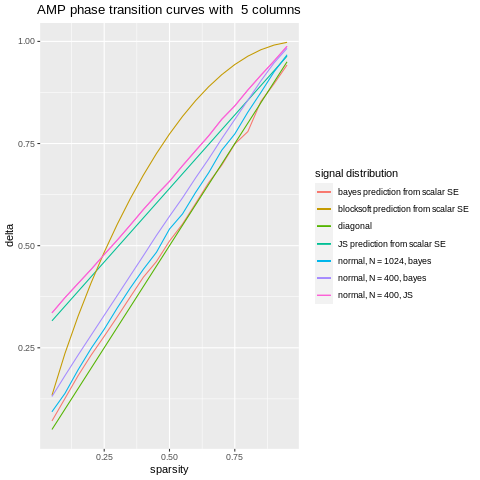

In [ ]:
%%R
# james stein plot
B = 5
g2 <- ggplot(res_normal_js, aes(x = sparsity, y = delta)) +
    labs(title = paste("AMP phase transition curves with ", B, "columns")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_line(aes(x = sparsity, y = empirical_delta_PT, color = "normal, N = 400, JS"))+
    geom_line(aes(x = sparsity, y = pred_JS_PT, color = "JS prediction from scalar SE")) +
    geom_line(aes(x = sparsity, y = pred_blocksoft_PT, color = "blocksoft prediction from scalar SE")) +
    geom_line(data = res_normal_js, aes(x = sparsity, y = empirical_delta_PT, color = "normal, N = 400, JS")) +
    # geom_line(aes(x = sparsity, y = pred_JS_upper_bound, color = "JS upper bound")) +
    # geom_line(aes(x = sparsity, y = pred_JS_approx_1st, color = "JS approximate (1st order)")) +
    # geom_line(aes(x = sparsity, y = pred_JS_approx_2nd, color = "JS approximate (2nd order)")) +
    # geom_line(data = res_poisson_bs, aes(x = sparsity, y = empirical_delta_PT, color = "poisson, N = 400, blocksoft"))+
    # geom_line(data = res_normal_bs, aes(x = sparsity, y = empirical_delta_PT, color = "normal, N = 400, blocksoft"))+
    geom_line(data = res_normal_bayes, aes(x = sparsity, y = empirical_delta_PT, color = "normal, N = 400, bayes"))+
    geom_line(data = res_normal_bayes, aes(x = sparsity, y = pred_bayes_PT, color = "bayes prediction from scalar SE"))+
    geom_line(data = res_normal_bayes, aes(x = sparsity, y = sparsity, color = "diagonal"))+
    geom_line(data = res_normal_bayes_small, aes(x = sparsity, y = empirical_delta_PT, color = "normal, N = 1024, bayes"))+
    scale_color_discrete(name = "signal distribution")

g2

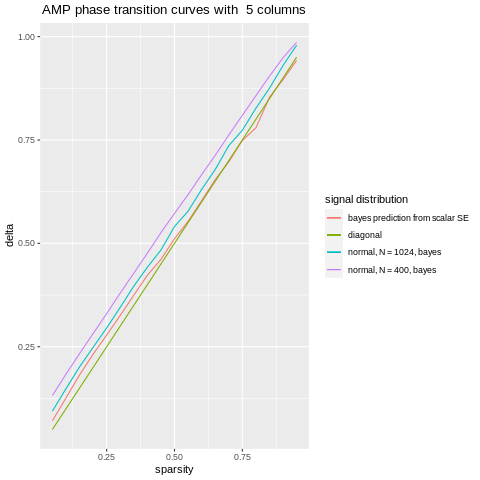

In [ ]:
%%R
# james stein plot
B = 5
g2 <- ggplot(res_normal_bayes, aes(x = sparsity, y = delta)) +
    labs(title = paste("AMP phase transition curves with ", B, "columns")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_line(data = res_normal_bayes, aes(x = sparsity, y = empirical_delta_PT, color = "normal, N = 400, bayes"))+
    geom_line(data = res_normal_bayes, aes(x = sparsity, y = pred_bayes_PT, color = "bayes prediction from scalar SE"))+
    geom_line(data = res_normal_bayes_small, aes(x = sparsity, y = empirical_delta_PT, color = "normal, N = 1024, bayes"))+
    geom_line(data = res_normal_bayes_small, aes(x = sparsity, y = sparsity, color = "diagonal"))+
    scale_color_discrete(name = "signal distribution")

g2

In [ ]:
# python code to compute minimax PT
import numpy as np
import autograd.numpy as anp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import scipy.optimize
import time


def multivariate_normal_pdf(y: np.ndarray, mean: np.ndarray, cov: np.ndarray) -> float:
    """
    Returns the multivariate normal pdf at y, provided some checks are satisfied.
    If condition number is large, returns 0.
    If condition number is ok but somehow the quadratic form in gaussian exponent is positive, returns 0.

    Parameters
    ----------
    y : np.ndarray
        Array at which normal pdf is to be calculated.
    mean : np.ndarray
        Mean of normal distribution.
    cov : np.ndarray
        Covariance of normal distribution.
    cov_condition : float
        Condition number of covariance.

    Returns
    -------
    float
        DESCRIPTION.

    """
    # cov_eigvals = np.linalg.eigh(cov)[0]
    # cov_eigvals_sorted = np.sort(np.abs(cov_eigvals))
    # cov_condition = cov_eigvals_sorted[-1]/cov_eigvals_sorted[0]
    if anp.linalg.det(cov) <= 0:
        return 0
    else:
        exponent = -anp.matmul(y - mean, anp.matmul(anp.linalg.inv(cov), y - mean))/2
        if exponent > 0 or anp.sqrt(anp.linalg.det(2*anp.pi*cov)) == 0:
            return 0
        else:
            return anp.exp(exponent)/anp.sqrt(anp.linalg.det(2*anp.pi*cov))


def normal_bayes_vec(y: np.ndarray,
                     signal_mean_vec: np.ndarray,
                     signal_cov: np.ndarray,
                     noise_cov: np.ndarray,
                     sparsity: float) -> np.ndarray:
    """
    Performs bayes denoising given noisy y = X + Z where X and Z are gaussian vectors with noise_cov non-singular.

    Parameters
    ----------
    y : np.ndarray
        noisy signal.
    signal_mean_vec : np.ndarray
        mean of signal X.
    signal_cov : np.ndarray
        cov of signal X.
    noise_cov : np.ndarray
        cov of noise Z.
    sparsity : float
        X is assumed to be gaussian w.p. sparsity, and else entirely zero.

    Returns
    -------
    np.ndarray
        Returns E(X | X + Z = y).

    """
    nonzero_bayes = signal_mean_vec + anp.matmul(signal_cov, anp.matmul(anp.linalg.inv(signal_cov + noise_cov), y - signal_mean_vec))
    num = sparsity*multivariate_normal_pdf(y, mean = signal_mean_vec, cov = signal_cov + noise_cov)
    deno = num + (1-sparsity)*multivariate_normal_pdf(y, mean = anp.zeros_like(signal_mean_vec), cov = noise_cov)
    if deno > 0:
        conditional_nonzero_prob = num/deno
        return conditional_nonzero_prob * nonzero_bayes
    else:
        return nonzero_bayes


def normal_bayes(X: np.ndarray,
                 signal_mean_vec: np.ndarray,
                 signal_cov: np.ndarray,
                 noise_cov: np.ndarray,
                 sparsity: float) -> np.ndarray:
    """
    Applies bayes denoiser to each row of signal matrix when noise_cov is non-singular.

    Parameters
    ----------
    X : np.ndarray
        Noisy signal along whose rows denoiser is to be applied.
    signal_mean_vec : np.ndarray
        mean of signal rows.
    signal_cov : np.ndarray
        cov of signal rows.
    noise_cov : np.ndarray
        cov of noise. Needs to be nonsingular.
    sparsity : float
        sparsity level.

    Returns
    -------
    np.ndarray
        Each row of X denoised by Bayes denoiser.

    """
    return np.apply_along_axis(normal_bayes_vec, 1, X, signal_mean_vec = signal_mean_vec, signal_cov = signal_cov, noise_cov = noise_cov, sparsity = sparsity)


def normal_bayes_risk_zero(signal_mean_vec: np.ndarray,
                           signal_cov: np.ndarray,
                           noise_var: np.ndarray,
                           sparsity: float) -> float:
    B = len(signal_mean_vec)
    rv = multivariate_normal(mean = np.zeros_like(signal_mean_vec, dtype = float), cov = noise_var*np.eye(B), allow_singular=True)
    noise = rv.rvs(10000)
    denoised = normal_bayes(noise, signal_mean_vec, signal_cov, noise_var*np.eye(B), sparsity)
    return np.trace(np.matmul(denoised.T, denoised)/denoised.shape[0])/denoised.shape[1]


def normal_bayes_risk_nonzero(signal_mean_vec: np.ndarray,
                               signal_cov: np.ndarray,
                               noise_var: float,
                               sparsity: float) -> float:
    B = len(signal_mean_vec)
    rv_noise = multivariate_normal(mean = np.zeros_like(signal_mean_vec), cov = noise_var*np.eye(B), allow_singular = True)
    noise = rv_noise.rvs(10000)
    rv_signal = multivariate_normal(mean = signal_mean_vec, cov = signal_cov, allow_singular = True)
    signal = rv_signal.rvs(10000)
    denoised = normal_bayes(signal + noise, signal_mean_vec, signal_cov, noise_var*np.eye(B), sparsity)
    resid = denoised - signal
    return np.trace(np.matmul(resid.T, resid)/resid.shape[0])/resid.shape[1]


def normal_bayes_risk(signal_mean_vec: np.ndarray,
                    signal_cov: np.ndarray,
                    noise_var: float,
                    sparsity: float) -> float:
    return (sparsity*normal_bayes_risk_nonzero(signal_mean_vec, signal_cov, noise_var, sparsity)) + ((1-sparsity)*normal_bayes_risk_zero(signal_mean_vec, signal_cov, noise_var, sparsity))


def state_evolution(signal_mean_vec: np.ndarray,
                    signal_cov: np.ndarray,
                    noise_var: float,
                    sparsity: float,
                    delta: float) -> np.ndarray:
    return normal_bayes_risk(signal_mean_vec,
                             signal_cov,
                             noise_var/delta,
                             sparsity)


def state_evolution_trajectory(signal_mean_vec: np.ndarray,
                                signal_cov: np.ndarray,
                                sparsity: float,
                                delta: float,
                                max_iter: int):
    B = len(signal_mean_vec)
    iter = 0
    noise_var = sparsity*np.trace(signal_cov + np.matmul(signal_mean_vec.reshape((B, 1)), signal_mean_vec.reshape((1, B))))/(B*delta)
    # noise_var = 1e-5
    noise_var_list = [noise_var]
    # print("iteration "+str(iter)+":"+str(noise_var))
    while iter<max_iter:
        iter = iter+1
        noise_var = state_evolution(signal_mean_vec,
                                    signal_cov,
                                    noise_var,
                                    sparsity,
                                    delta)
        noise_var_list = noise_var_list + [noise_var]
        print("iteration "+str(iter)+":"+str(noise_var))
    return noise_var_list


def max_normal_bayes_risk(signal_mean_vec: np.ndarray,
                          signal_cov: np.ndarray,
                          sparsity: float):
    def f(noise_var, signal_mean_vec, signal_cov, sparsity):
        return 1-(normal_bayes_risk(signal_mean_vec, signal_cov, noise_var, sparsity)/noise_var)
    start_time = time.time()
    res = scipy.optimize.minimize_scalar(f, bounds=(1e-3, 10), args = (signal_mean_vec, signal_cov, sparsity), method = 'bounded').fun
    end_time = time.time()
    return 1-res


In [ ]:
PT_df = pd.read_csv('normal_bayes_PT.csv')
PT_df['sparsity'] = [round(x, 2) for x in PT_df['sparsity']]

In [ ]:
np.array(PT_df['sparsity'] == 0.05)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [ ]:
# coarser sparsity grid: undersampling based on dataframe
def update_undersampling_int_grid_coarse_bayes_PT(signal_nrow, signal_ncol, sparsity, band_half_width, mean_vec, signal_cov, PT_df):
  # PT = max_normal_bayes_risk(mean_vec, signal_cov, sparsity)
  dat_small = PT_df[PT_df['sparsity'] == sparsity]
  PT = dat_small['bayes_PT'].item()
  undersampling_int_lower = max(1, int(signal_nrow * max(0, PT - band_half_width)))
  undersampling_int_upper = min(signal_nrow - 1, int(signal_nrow * min(1, PT + band_half_width)))
  range_list = range(undersampling_int_lower, undersampling_int_upper + 1)
  return [min(range_list), np.percentile(range_list, 25), np.median(range_list), np.percentile(range_list, 75), max(range_list)]
  # return list(range_list)

update_undersampling_int_grid_coarse_bayes_PT(1600, 5, 0.5, 0.01, np.zeros(5), np.eye(5), PT_df)

[802, 810.0, 818.0, 826.0, 834]

In [ ]:
# coarser sparsity grid: undersampling based on predicted
def update_undersampling_int_grid_coarse_bayes(signal_nrow, signal_ncol, sparsity, band_half_width, mean_vec, signal_cov):
  PT = max_normal_bayes_risk(mean_vec, signal_cov, sparsity)
  undersampling_int_lower = max(1, int(signal_nrow * max(0, PT - band_half_width)))
  undersampling_int_upper = min(signal_nrow - 1, int(signal_nrow * min(1, PT + band_half_width)))
  return list(range(undersampling_int_lower, undersampling_int_upper + 1))

update_undersampling_int_grid_coarse_bayes(400, 5, 0.3, 0.05, np.zeros(5), np.eye(5))

In [ ]:
%%R
optimize(normal_bayes_risk, c(0, 1e+10), epsilon = 0.2, B = 10, mean_vec = rep(0, 10), signal_cov = diag(10), maximum = TRUE)

$maximum
[1] 0.02386728

$objective
[1] 0.2006996



In [ ]:
# bayes amp experiment dicts
def dict_experiment(PT_df) -> dict:
  total_params = 0
  exp = dict(table_name='AMP_matrix_recovery_normal_bayes_approx_jacobian',
             base_index=0,
             description='Performs Bayes denoising with complete knowledge of sparsity and signal characteristics. Nonzeros of signal iid N(0,1). Sparsity varies from 0.05 to 0.95 in increment of 0.05. Signal rows vary in [1600, 3200] and 5 columns. Undersampling integer grid half-width 0.05 around the predicted PT value which is max Bayes risk. Only min, quartiles and max of the interval are taken. 25 MC runs per param point. Jacobian approximated by selecting only 150 signal rows randomly.',
             db_url='sqlite:///data/EMS.db3',
             multi_res=[])
  mr = exp['multi_res']
  signal_nrow_grid = [1600, 3200]
  signal_ncol_grid = [5]
  sparsity_grid = [round(x, 2) for x in np.linspace(0.05, 0.95, num = 19)]
  for signal_nrow in signal_nrow_grid:
    for signal_ncol in signal_ncol_grid:
      for sparsity in sparsity_grid:
        d = {
            'nonzero_rows': [round(signal_nrow * sparsity)],
            'num_measurements': [round(x) for x in update_undersampling_int_grid_coarse_bayes_PT(signal_nrow, signal_ncol, sparsity, 0.1, np.zeros(signal_ncol), np.eye(signal_ncol), PT_df)],
            'signal_nrow': [round(signal_nrow)],
            'signal_ncol': [round(signal_ncol)],
            'mc': list(range(25)),
            'max_iter': [500],
            'err_tol': [1e-5],
            'sparsity_tol': [1e-4],
            'err_explosion_tol': [100],
            'selected_rows_frac': [round(150/signal_nrow, 2)]
            }
        mr.append(d)
        total_params = total_params + len(d['num_measurements'])*len(d['mc'])*len(d['selected_rows_frac'])
  print(total_params)
  return exp

In [ ]:
# real experiment json creation
def dict_experiment_json(PT_df):
  exp = dict_experiment(PT_df)
  with open('AMP_matrix_recovery_normal_bayes_approx_jacobian_2.json', 'w') as json_file:
      json.dump(exp, json_file, indent = 4)

dict_experiment_json(PT_df)

4750


# Scaling laws

In [ ]:
%%R
res_normal_bayes_1024 = dplyr::filter(res_normal_bayes, signal_nrow == 1024)
offset = res_normal_bayes_1024$empirical_delta_PT
res_normal_bayes_else = dplyr::filter(res_normal_bayes, signal_nrow != 1024)
# res_normal_bayes_else = dplyr::filter(res_normal_bayes_else, signal_nrow != 100)
# res_normal_bayes_else$diff = res_normal_bayes_else$empirical_delta_PT - rep(offset, 5)


In [ ]:
%%R
alpha_grid = seq(0.01, 1, by = 0.01)
R_grid = rep(0, length(alpha_grid))
res_normal_bayes_else$signal_nrow = as.numeric(res_normal_bayes_else$signal_nrow)
for(i in 1:length(alpha_grid)){
    R_grid[i] = summary(lm(diff ~ I(signal_nrow^(-alpha_grid[i]))-1, data = res_normal_bayes_else))$r.squared
}
i = which.max(R_grid)
summary(lm(diff ~ I(signal_nrow^(-alpha_grid[i])) - 1, data = res_normal_bayes_else))

  variable lengths differ (found for 'I(signal_nrow^(-alpha_grid[i]))')




Error in model.frame.default(formula = diff ~ I(signal_nrow^(-alpha_grid[i])) -  : 
  variable lengths differ (found for 'I(signal_nrow^(-alpha_grid[i]))')


In [ ]:
%%R
alpha_grid = seq(0.01, 3, by = 0.01)
R_grid = rep(0, length(alpha_grid))
res_normal_bayes_else$signal_nrow = as.numeric(res_normal_bayes_else$signal_nrow)
for(i in 1:length(alpha_grid)){
    R_grid[i] = summary(lm(empirical_delta_PT ~ as.factor(sparsity) + I(signal_nrow^(-alpha_grid[i]))-1, data = res_normal_bayes_else))$r.squared
}
i = which.max(R_grid)
summary(lm(empirical_delta_PT ~ as.factor(sparsity) + I(signal_nrow^(-alpha_grid[i])) - 1, data = res_normal_bayes_else))


Call:
lm(formula = empirical_delta_PT ~ as.factor(sparsity) + I(signal_nrow^(-alpha_grid[i])) - 
    1, data = res_normal_bayes_else)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.094719 -0.006725 -0.001154  0.006112  0.040724 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
as.factor(sparsity)0.05          0.086676   0.009265   9.355 3.15e-14 ***
as.factor(sparsity)0.1           0.145725   0.009265  15.728  < 2e-16 ***
as.factor(sparsity)0.15          0.194657   0.009265  21.010  < 2e-16 ***
as.factor(sparsity)0.2           0.243896   0.009265  26.324  < 2e-16 ***
as.factor(sparsity)0.25          0.291346   0.009265  31.446  < 2e-16 ***
as.factor(sparsity)0.3           0.340496   0.009265  36.751  < 2e-16 ***
as.factor(sparsity)0.35          0.385757   0.009265  41.636  < 2e-16 ***
as.factor(sparsity)0.4           0.433776   0.009265  46.818  < 2e-16 ***
as.factor(sparsity)0.45          0.482825   0.009265  52.112  < 2e-16 

In [ ]:
%%R
alpha_grid[which.max(R_grid)]

[1] 0.98


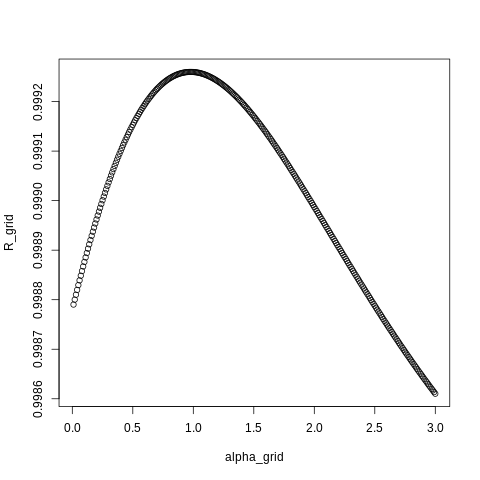

In [ ]:
%%R
plot(alpha_grid, R_grid)

In [ ]:
%%R
dat = read.csv("normal_bayes_PT.csv")
dat

    X sparsity   bayes_PT
1   0     0.05 0.07082796
2   1     0.10 0.12618309
3   2     0.15 0.18173291
4   3     0.20 0.23204123
5   4     0.25 0.27822505
6   5     0.30 0.32572331
7   6     0.35 0.37458320
8   7     0.40 0.42279817
9   8     0.45 0.46116929
10  9     0.50 0.51131287
11 10     0.55 0.55307532
12 11     0.60 0.60327705
13 12     0.65 0.65427612
14 13     0.70 0.69686183
15 14     0.75 0.74894213
16 15     0.80 0.77918815
17 16     0.85 0.85324494
18 17     0.90 0.89594464
19 18     0.95 0.94222177
